/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


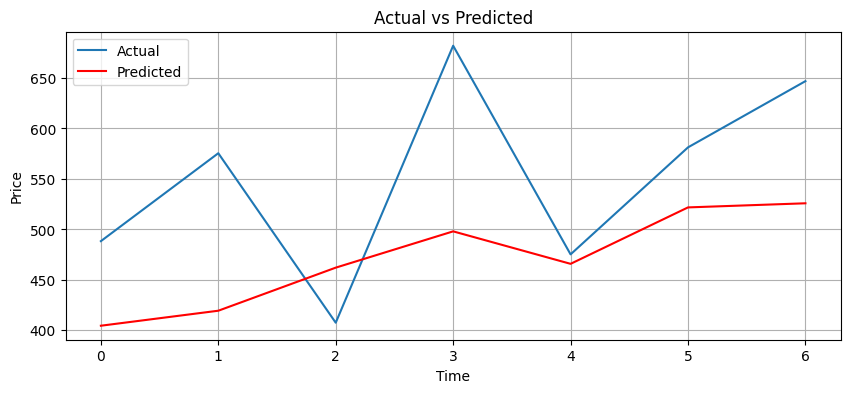

Root Mean Squared Error (RMSE): 111.11


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Step 1: Load the dataset
file_path = 'Dataset.csv'
data = pd.read_csv(file_path)

# Step 2: Prepare the date column
data['month'] = data['month'] + '-2020'  # Add dummy year
data['month'] = pd.to_datetime(data['month'], format='%d-%b-%Y')
data.set_index('month', inplace=True)

# Step 3: Handle missing values
data['price'] = data['price'].interpolate()

# Step 4: Normalize the data
scaler = MinMaxScaler()
data['price_scaled'] = scaler.fit_transform(data[['price']])

# Step 5: Create lag features
def create_dataset(series, n_lags=3):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i-n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

n_lags = 3
X, y = create_dataset(data['price_scaled'].values, n_lags)

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 7: Build the Neural Network
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=n_lags))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mse')

# Step 8: Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

# Step 9: Predict
y_pred = model.predict(X_test)

# Inverse transform to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Step 10: Plot Actual vs Predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Evaluate
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
